### **Problem Statement**

The dataset is used for this problem is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting whether a claim will be made on an insurance policy. Although the features are anonymized, they have properties relating to real-world features.The real challenge with this data is it has 119 features and almost one million records for training

https://www.kaggle.com/c/tabular-playground-series-sep-2021/data

My objective in this notebook to reduce the size of features atleast 20% using unsupervised learning technique autoencoders without losing any significant model performance.Too many features leads to over-fitting when learning a model, reducing feature size with some compression technique helps to generalize model well

In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import math
import gc
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
# import math
# from scipy import stats # For outlier handling

'''''''''
torch
'''''''''
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.optim 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
print(torch.__version__)

'''''''''
optuna
'''''''''
import optuna
from optuna.trial import TrialState

'''''''''
Sklearn 
'''''''''
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import accuracy_score,roc_auc_score

'''''''''
Light Gradient Boosting Machine
'''''''''
!pip install lightgbm
import lightgbm as lgb

'''''''''
XGb
'''''''''
import xgboost as xgb
from xgboost import XGBClassifier

'''''''''''''''
Feature Engine
'''''''''''''''
!pip install feature_engine
from feature_engine.selection import SmartCorrelatedSelection

## **1) Read Data**

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
print(f'train {train.shape}')

In [ ]:
train.head()

#### **Findings**

- Given data set is for classification
- It has 118 features from "f1" to "f118" excluding "id" and target feature "claim"
- Target feature is claim (1 or 0)

## **2) EDA**

#### **2.1) Target Feature Distribution**

In [ ]:
plt.figure(figsize=(8,4))
mean = (train.claim.values == 1).mean()
ax = sns.barplot(['Claim', 'Not Claim'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='Calim vs Not Claim')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")
plt.show()    
Summarydf = train.groupby('claim')['id'].count().reset_index()
Summarydf.columns = ['claim','count']
Summarydf['total'] = len(train)
Summarydf['perc']  = round((Summarydf['count']/Summarydf['total']),2)*100
Summarydf

#### **Findings**

- Claim vs not Claim rate are almost 50%
- Given data is balanced
- We dont need to balance data using any sampling technique , or associate weights with classes during training 

#### **2.2) Missing Data**

In [ ]:
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Missing'] = df.isna().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

summary(train)

#### **Findings**

- Most of the features data are missing 
- As given data is synthetically generated we can't judge which column has to keep and impute  
- For single missing values or for values missing less than 5% simple imputation is fine,simple imputation is mean / median / mode. But if it is more than 5% then here a MICE helps , it is a multiple imputation by chain equation. In this notebook i will use simple imputation technique
- Based on during Kaggle competition most of the competitors used this missing as a new feature which boosted score by 1% which is a lot to climb on public/private leaderboard. 
- On the backend i tried to use MICE imputation and gave up as missingness is not in one column , it is almost in all columns so it deos not make sense to use MICE technique in this situation , if you want to see further MICE detail then have a look here https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained

#### **2.3) Density plots features w.r.t (claim) feature**

In [ ]:
def plot_feature_distribution(df, features):
    fig,axes = plt.subplots(40,3,figsize=(30,150))
    plt.style.use('ggplot')
    
    for col,ax in zip(features,axes.flat):

        sns.kdeplot(df.loc[(df['claim']==1),col], color='purple', shade=False,ax=ax, label='Claim',alpha=0.5)
        sns.kdeplot(df.loc[(df['claim']==0),col], color='green', shade=False,ax=ax, label='Not Claim',alpha=0.5)
        ax.legend(loc='upper right')
        plt.xlabel(col, fontsize=18)
        plt.tight_layout()

features = [feature for feature in train.columns if feature not in ['id','claim']]
plot_feature_distribution(train, features)

#### **Findings**

- Features are too much overlapped for the given  target claim '1' and '0'
- Some features are bimodal and some are multi modal, it means features are from different subgroups
- Some features are too much left or right skewed
- Its quite challenging to generate new features which seperate given data from claim '1' to '0'
- Autoencoder may help , it needs to be explored

#### **2.4) Correlated Features**

In [ ]:
# Row wise Missing count for each columns - feature generation
train['nan_count'] = train.isnull().sum(axis=1)
# impute simple mean imputation
train.fillna(train.mean(),inplace=True)

# set up the selector
tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

Xt = tr.fit_transform(train.drop(['id','claim'],axis=1))
tr.correlated_feature_sets_

#### **Findings**

* Threshold for given dataset feature correlation is 0.8 , none of any features are highly correlated to each other
* If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task for autoencoder

## **3) Data Processing**

In [ ]:
class dataProcessing:
    
    def __init__(self,data,feature):
        self.X        = data.copy()
        self.feature  = feature

    def robustScaling(self):
        # Scaling data
        scaler = RobustScaler()
        scaler.fit(self.X[self.feature])
        X = scaler.transform(self.X[self.feature])
        scalerfile = 'robust_scaler.sav'
        pickle.dump(scaler, open(scalerfile, 'wb'))
        return X
    def standardScaling(self):
        # Scaling data
        scaler = StandardScaler()
        scaler.fit(self.X[self.feature])
        X = scaler.transform(self.X[self.feature])
        scalerfile = 'standard_scaler.sav'
        pickle.dump(scaler, open(scalerfile, 'wb'))
        return X
    def minMaxScaling(self):
        # Scaling data
        scaler = MinMaxScaler()
        scaler.fit(self.X[self.feature])
        X = scaler.transform(self.X[self.feature])
        scalerfile = 'minmax_scaler.sav'
        pickle.dump(scaler, open(scalerfile, 'wb'))        
        return X

In [ ]:
# Drop target features
X = train.drop(['id','claim'],axis=1)
# move target features
y = train['claim']
X

## **4) Base Line Models**

In [ ]:
# LGBM parameters
best_params = {'n_estimators': 1000, 
               'subsample': 0.4, 
               'learning_rate': 0.01, 
               'num_leaves': 70, 
               'is_unbalance':False,
               'device': 'gpu'}
    
gbm = lgb.LGBMClassifier(**best_params)

# OOF predictions
scores = list()
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# enumerate splits
for train_idx, test_idx in kfold.split(X,y):

    # get train fold data
    train_X, test_X = X.loc[train_idx,:], X.loc[test_idx,:]
    train_y, test_y = y.loc[train_idx], y.loc[test_idx]

    # fit model on train fold data
    gbm.fit(train_X, train_y)
    # predict on test fold data
    pred = gbm.predict_proba(test_X)[:, 1] # This grabs the positive class prediction
    # get accuracy score
    cv_score  = roc_auc_score(test_y, pred)
    # store score
    scores.append(cv_score)
    print('> ', cv_score)
# summarize model performance
mean_s, std_s = np.mean(scores), np.std(scores)
print('Mean: %.5f, Standard Deviation: %.5f' % (mean_s, std_s))

#### **Findings**

- With all given features and generated new features "nan_count" , model is giving 0.81351 accuracy score which is a good starting point
- We will try to reduce feature space first using Autoencoder technique.Reduced feature space may lead to enhance model performance using hyperparameter tuning

## **5) Autoencoder**

### **5.1) What is Autoencoder**

- Autoencoders are an unsupervised learning technique in which we use neural network that attempts to do two things

    1- It compresses input data knowledge into a lower dimnesion
    
    2- Then it uses this lower dimensional representation of the data to recreate the original input
    
- the difference between the attempted recreation and the original input is called reconstruction error , by training the network to minimize this reconstruction error on given dataset the network learns to exploit the natural structure (Latent Representation) in your data to find an efficient lower dimensional representation

- Left part of the network is called encoder, its job to transform the original input into a lower dimensional represnetation (Latent Representation). Our real data is not random but instead it has structure and sturcture means we do'nt need every part of our full input space to represent our data , its the encoders job to map it from that full input space into a meaningful lower dimension

- Right part of the network is called decoder, it recreate the original input using the output of the encoder, it tries to reverse the encoding process. It tries to recreate a higher dimensional thing using a lower dimensional thing (middle layer) by training the whole network to minimze the reconstruction error.Training network with different epochs find the weights that minimize the reconstruction error

- The whole process is to force encoder and decoder to work together to find the most efficient way to condense the input data into lower dimension

- As we have 118 features , we will try to compress it first by 95 features and will see how above base model LGBM score 
  on these new representation of data

- We will not use simple Autoencoder,we will use swap noise Autoencoder.What is it and why to use it? see next section below

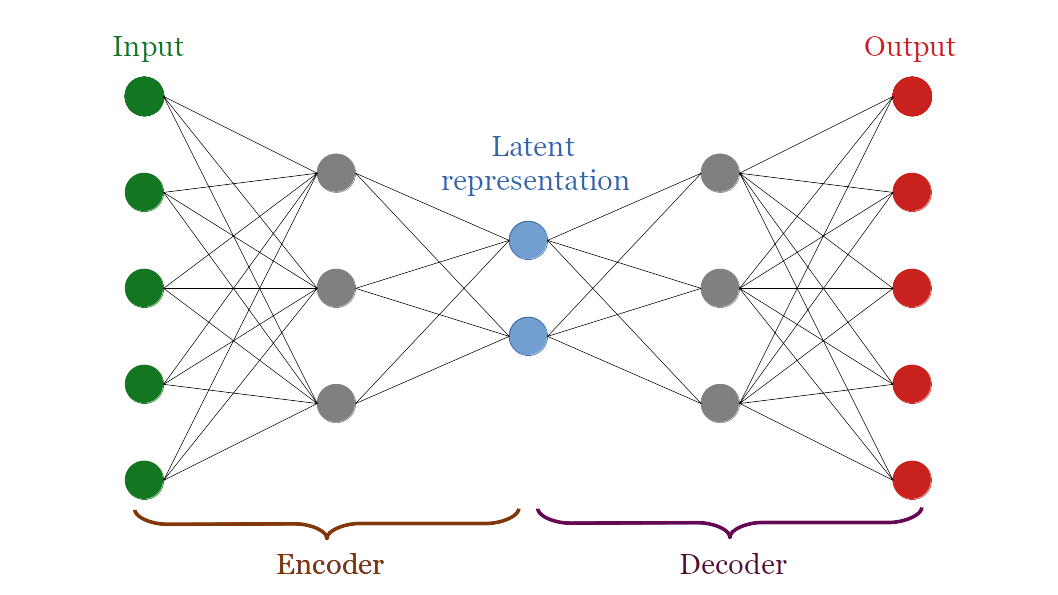

### **5.2) Swap Denoising Autoencoder**

- Before understanding Swap Denoising Autoencoder (DAE) , we must understand what is noise and why it is useful. In mathematics there is an identity function , a function always return the same value as its an input , for example f(x) = x for the domain of integer {1,2,3,4}. This identity function will always yield f(x) --> 1,2,3,4.In simple Autoencoder hidden layers learn generate complex relations between the given inputs ,generated noise try to decrease dependency of these learned relations so it can avoid identity.Noises randomly apply so the same input at different time can learn something different rather than depend on one unified relations.

- There are different techniques to generate noise, it depends from one data to another data. Image data and tabular data has different proximity.We have tabular data,we will use swap noise where we will swap some defined percentage of input data in each batch,for example if we have 5 rows with 3 columns data as show below then in a batch 20% swapping noise will effect one column in each batch iterations as 20% of 5 rows is 1.For more clarity see example below

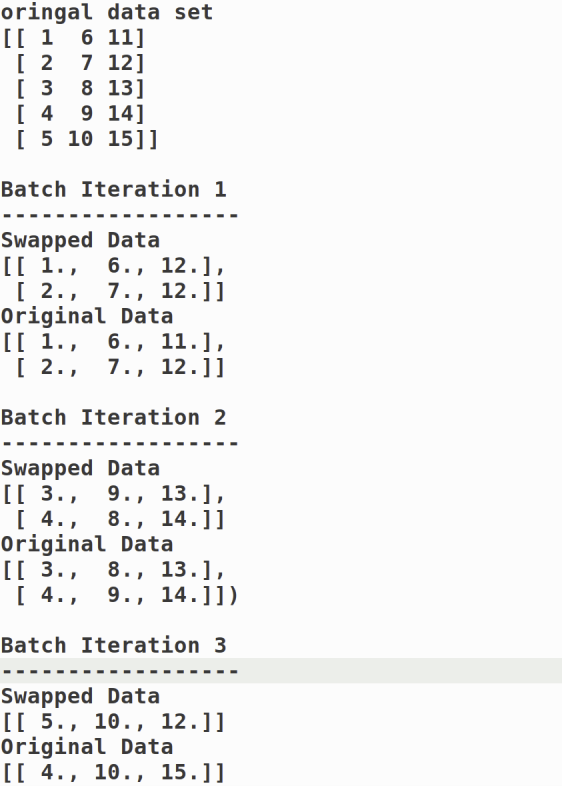

## **6) Scaling Data**

- Any neural network works best on scaled data to calculate gradeints

In [ ]:
features = [var for var in X.columns]

# Scaling Data
dataObj   = dataProcessing(X,features)
X_scaled  = pd.DataFrame(dataObj.robustScaling())
X_scaled.columns = features
X_scaled

In [ ]:
print(train.shape,X_scaled.shape)

## **7) Swap Data Set Class**

In [ ]:
class swapDataset:
    def __init__(self, features, noise):
        self.features = features
        self.noise = noise
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        
        sample = self.features[idx, :].copy()
        sample = self.swap_sample(sample)
        dct = {
            'x' : torch.tensor(sample, dtype=torch.float),
            'y' : torch.tensor(self.features[idx, :], dtype=torch.float)            
        }
        return dct
    
    def swap_sample(self,sample):
            num_samples = self.features.shape[0]
            num_features = self.features.shape[1]
            if len(sample.shape) == 2:
                batch_size = sample.shape[0]
                random_row = np.random.randint(0, num_samples, size=batch_size)
                for i in range(batch_size):
                    random_col = np.random.rand(num_features) < self.noise
                    sample[i, random_col] = self.features[random_row[i], random_col]
            else:
                batch_size = 1
                random_row = np.random.randint(0, num_samples, size=batch_size)
                random_col = np.random.rand(num_features) < self.noise
                sample[ random_col] = self.features[random_row, random_col]
                
            return sample

## **8) Autoencoder Class**

In [ ]:
'''''''''''''''
Optimizer
'''''''''''''''
def get_optimizer(model):
    '''
    To keep the weights small and avoid exploding gradient. Because the L2 norm of the weights are added to the 
    loss, each iteration of your network will try to optimize/minimize the model weights in addition to the loss. 
    This will help keep the weights as small as possible, preventing the weights to grow out of control, and thus 
    avoid exploding gradient
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2,factor=0.001,threshold=1e2)    
  
    return optimizer,scheduler

'''''''''''''''
Weights
'''''''''''''''
def init_weights(m):
    if type(m) == nn.Linear:
        '''
        This is an example i created as instructed by Andrew Ng course
        torch.ones([10, 6])*torch.sqrt(torch.Tensor([2.])/torch.Tensor([1.4142]))
        '''
        m.weight.data = torch.randn(m.weight.size())*torch.sqrt(torch.Tensor([1.])/m.weight.size()[1])
      
'''''''''''''''
Autoencoder
'''''''''''''''
class Autoencoder(nn.Module):
    # instantiate the object created using this class
    def __init__(self):
        super().__init__()
        m = nn.Dropout(p=0.2)
        
        '''
        Techniques like alternate weight initialization schemes and alternate activation functions can be used to reduce the impact of 
        the vanishing gradients problem for feed-forward neural networks. 
        '''
        # FC (Fully Connected Layer) -> BatchNorm -> ReLu(or other activation) -> Dropout -> FC ->
        self.encoder = nn.Sequential(
            nn.Linear(119,480),
            nn.BatchNorm1d(480),            
            nn.ReLU(),

            nn.Linear(480,95),
            nn.BatchNorm1d(95),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(95,480),
            nn.BatchNorm1d(480),                        
            nn.ReLU())
            
        self.decoder_recon = nn.Linear(480,119)
        self.decoder_classifier = nn.Linear(480,119)

    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        reconstruction = self.decoder_recon(x)
        logits = self.decoder_classifier(x)
        
        return reconstruction,logits
    
    def get_encoder_state(self,x):
        encoded = self.encoder(x)
        return encoded

##  **9) Create Dataset & Data Loader Using Swapping Class**

In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''
Swapping Dataset and create data loader
'''''''''''''''''''''''''''''''''''''''''''''
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = swapDataset(X_scaled.values,0.2) # Swapping data 
data_loader   = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

'''''''''''''''''''''''''''''''''''''''''''''
Define Model
'''''''''''''''''''''''''''''''''''''''''''''
autoencoder = Autoencoder()

'''''''''''''''''''''''''''
Attach Weights to model
'''''''''''''''''''''''''''
autoencoder.apply(init_weights)

'''''''''''''''''''''
Define Loss function
'''''''''''''''''''''
criterion = nn.MSELoss()

'''''''''''''''''''''''''''
Load Optimizer and scheduler
'''''''''''''''''''''''''''
optimizer,scheduler = get_optimizer(autoencoder)
autoencoder.to(device)

##  **10) Training Network**

In [ ]:
seed = 4
torch.manual_seed(seed)

num_epochs = 200
outputs = []
running_loss = 0.0

for epoch in range(num_epochs):
    for data in data_loader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        recon,logits = autoencoder(inputs)
        loss_recon  = criterion(recon,targets) # calculate loss
        loss_classifier     = criterion(logits,inputs)
        loss = loss_classifier 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update weights 
        if not  scheduler.__class__ ==  torch.optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step(loss)
        running_loss += loss.item()
    
    if (epoch+1) % 2 ==0:
        print(f'Epoch: {epoch+1}, Loss:{loss_classifier}')

In [ ]:
# Save model for future use
# torch.save(autoencoder.state_dict(),'DAE_Auteoncoder.pth')

## **11) Encoding**

In [ ]:
# Load model if you want to use best model base on your checkpoint
# autoencoder.load_state_dict(torch.load('../input/daeautoencoderbest/DAE_Auteoncoder_best.pth'))
# autoencoder

In [ ]:
torch.cuda.empty_cache()
gc.collect()
# Convert to tensor
X_train = torch.from_numpy(pd.DataFrame(X_scaled).to_numpy(np.float32)).to(device)
# Encoded using autoencoder
X_train_encoded = autoencoder.get_encoder_state(X_train)
# transfer from tensor to dataframe
X = pd.DataFrame(X_train_encoded.cpu().detach().numpy())
X.shape

# **12) Downstream Models**

### **12.1) LGBM**

In [ ]:
best_params = {'n_estimators': 1000, 
               'subsample': 0.4, 
               'learning_rate': 0.01, 
               'num_leaves': 70, 
               'is_unbalance':False,
               'device': 'gpu'}
    
gbm = lgb.LGBMClassifier(**best_params)

# OOF predictions
scores = list()
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


# enumerate splits
for train_idx, test_idx in kfold.split(X,y):

    # get data
    train_X, test_X = X.loc[train_idx,:], X.loc[test_idx,:]
    train_y, test_y = y.loc[train_idx], y.loc[test_idx]

    # fit model
    gbm.fit(train_X, train_y)

    pred = gbm.predict_proba(test_X)[:, 1] # This grabs the positive class prediction
    cv_score  = roc_auc_score(test_y, pred)
    
    # store score
    scores.append(cv_score)
    print('> ', cv_score)
# summarize model performance
mean_s, std_s = np.mean(scores), np.std(scores)
print('Mean: %.5f, Standard Deviation: %.5f' % (mean_s, std_s))

### **Conclusion**

* In summary,latent space model overall score on unseen data is 0.80658.While without autoencoder,base line model is giving 0.81351. There is a loss of 0.006 with autoencoder technique which is not bad.Moving forward i will implement some other swapping techniques or some other type of autoencoder to break this 0.81351 benchmark with autoencoder.There could be some manifold which can exploit this data insights and boost overall score of this challenge.There could be some latent space which can be revealed using some other noise technique or using some other autoencoder types Convolutional Autoencoder or Deep Autoencoder for the same overlapped and uncorrelated data features.Please give any feedback to improve this approach and upvote if it helps you out to understand dimension reduction technique